In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
train_df = pd.read_csv("drugsComTrain_raw.csv") 
test_df = pd.read_csv("drugsComTest_raw.csv")

In [37]:
train_df.shape

(161297, 7)

In [38]:
test_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [40]:
train_df.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [41]:
train_df = train_df.dropna()

In [42]:
train_df.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [43]:
train_df.shape

(160398, 7)

In [44]:
train_df.duplicated().sum()

0

In [45]:
test_df.isnull().sum()

uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [46]:
test_df = test_df.dropna()

In [47]:
test_df.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

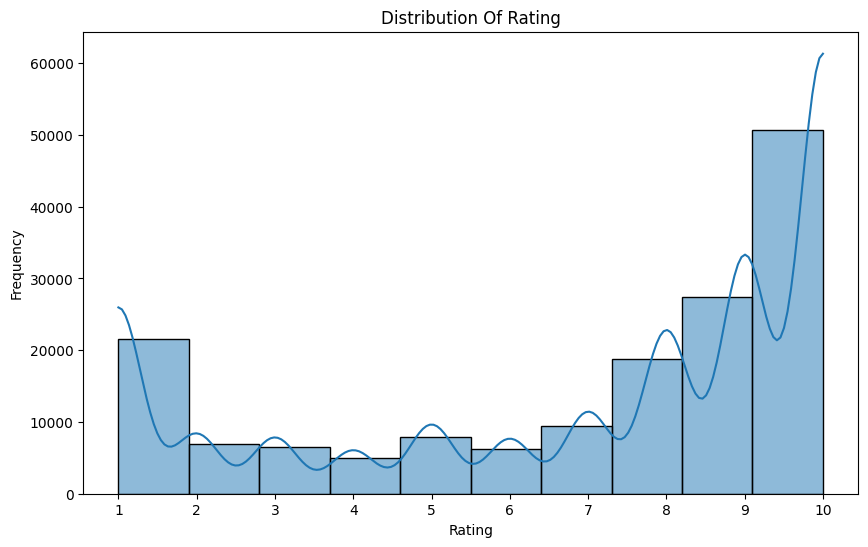

In [48]:
# Visualize the distribution of ratings in training data
plt.figure(figsize=(10,6))
sns.histplot(train_df['rating'], bins=10, kde=True)
plt.xticks(ticks = range(1,11), labels=range(1,11))
plt.title("Distribution Of Rating")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [49]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%d-%b-%y')

In [50]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [51]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

train_df['processed_review'] = train_df['review'].apply(preprocess_text)
train_df['processed_condition'] = train_df['condition'].apply(preprocess_text)

In [52]:
train_df['combined_text'] = train_df['processed_condition'] + " " + train_df['processed_review']

In [53]:
# TF-IDF Vectorization of combined text
vectorizer = TfidfVectorizer(max_features=500)
X_combined_text = vectorizer.fit_transform(train_df['combined_text']).toarray()

In [54]:
# TF-IDF Vectorization of combined text

numerical_features = train_df[['rating','usefulCount']].values

X_combined = np.hstack((X_combined_text, numerical_features))

In [55]:
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

In [56]:
pca = PCA(n_components=50)
X_combined_pca = pca.fit_transform(X_combined_scaled)

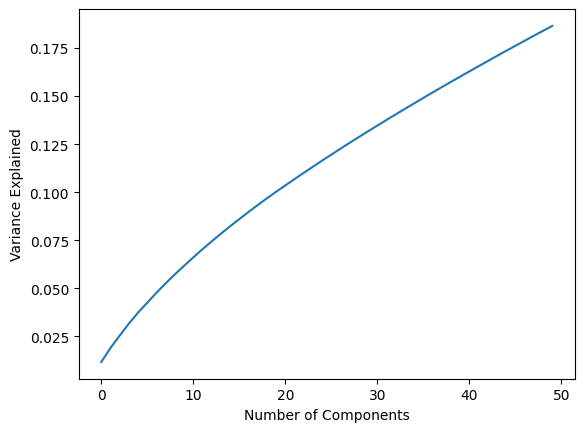

In [57]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

In [58]:
wcss = []  

for i in range(2, 11):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_combined_pca)
    wcss.append(kmeans.inertia_)

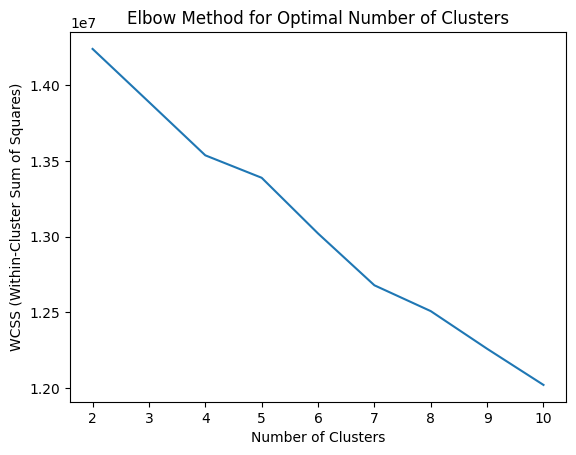

In [59]:
plt.plot(range(2, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [60]:
optimal_clusters = 5  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
train_df['Cluster'] = kmeans.fit_predict(X_combined_pca)


In [61]:
def recommend_drug(condition, top_n=3):
    # Preprocess the condition input
    processed_condition = preprocess_text(condition)
    
    # Transform the input condition using the same vectorizer
    input_condition_vector = vectorizer.transform([processed_condition]).toarray()
    
    # Combine with zeros for numerical features (dummy input for prediction)
    input_combined = np.hstack((input_condition_vector, np.zeros((1, numerical_features.shape[1]))))
    
    input_combined_scaled = scaler.transform(input_combined)
    
    input_combined_pca = pca.transform(input_combined_scaled)
    
    predicted_cluster = kmeans.predict(input_combined_pca)[0]
    
    recommended_drugs = train_df[train_df['Cluster'] == predicted_cluster]['drugName'].value_counts().head(top_n)
    
    return recommended_drugs.index.tolist()

user_condition = "Bipolar Disorde" 
recommended_drugs = recommend_drug(user_condition)
print(f"Recommended drugs for '{user_condition}': {recommended_drugs}")

Recommended drugs for 'Bipolar Disorde': ['Phentermine', 'Sertraline', 'Escitalopram']


In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.datasets import make_blobs
import numpy as np

# Generate sample data
X, true_labels = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)

# Predict cluster labels
cluster_labels = kmeans.predict(X)

# Calculate inertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Calculate silhouette score
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Adjusted Rand Index (requires ground truth labels)
ari = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari}")


Inertia: 212.00599621083478
Silhouette Score: 0.6819938690643478
Davies-Bouldin Index: 0.43756400782378385
Adjusted Rand Index: 1.0
